<a href="https://colab.research.google.com/github/davidbro-in/pds-fir-pipeline/blob/main/notebooks/fir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procesamiento digital de señales

## Filtro FIR con _pipeline_

### Alumnos

- Hanes Sciarrone
- David Broin

### Temas

- Señal con ruido para pruebas
- Filtro pasa bajos
- Filtro pasa altos
- Filtro pasa banda
- Filtro suprime banda


### Importar librerías necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as plot
from scipy.signal import lfilter
from tool._fixedInt import *

### Generación de señal para pruebas

Se generará una señal compuesta por los siguientes tonos:

- 500 Hz
- 2500 Hz
- 3000 Hz
- 4500 Hz

128


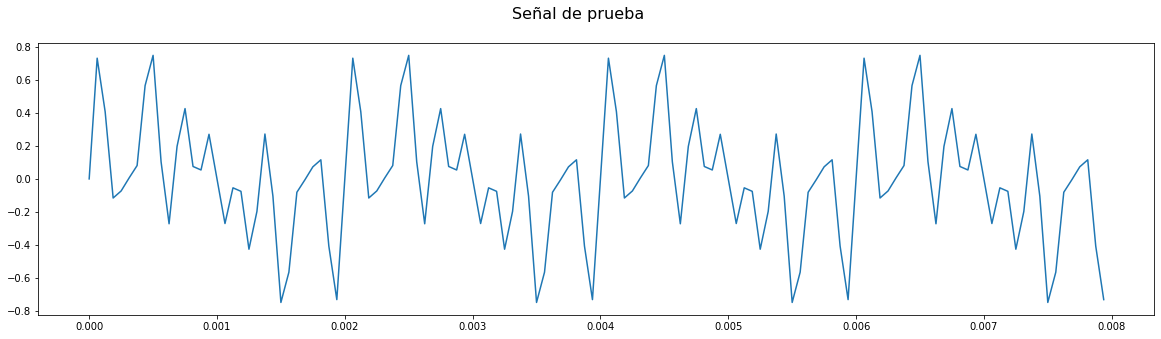

In [23]:
fs = 16000
sec = 0.007996
t = np.arange(0, fs*sec, 1)/fs

# Tonos generados a inyectar al sistema de filtrado
tones = (np.sin(2*np.pi * 500 *t) + np.sin(2*np.pi * 2500 *t) + 
         np.sin(2*np.pi * 3000 *t) + np.sin(2*np.pi * 4500 *t))/4


print(len(tones))

temp  = DeFixedInt(8,6, signedMode='S', roundMode='trunc', saturateMode='saturate')

filename = '../hdl/src/mem.hex'

with open(filename, 'w') as f:
    for sample in tones:
        temp.value = sample
        f.write("{}\n".format(temp.__hex__()).replace('0x',''))


fig = plt.figure(figsize=(20, 5))
fig.suptitle("Señal de prueba", fontsize=16)
plt.plot(t, tones);

In [24]:
def twos_complement(hexstr,bits):
    value = int(hexstr,16)
    if value & (1 << (bits-1)):
        value -= 1 << bits
    return value

In [25]:
with open('../hdl/src/mem.hex', 'r') as f:
    lines = f.readlines()
    arr = []
    for line in lines:
        arr.append(twos_complement(line.strip(), 8))

    

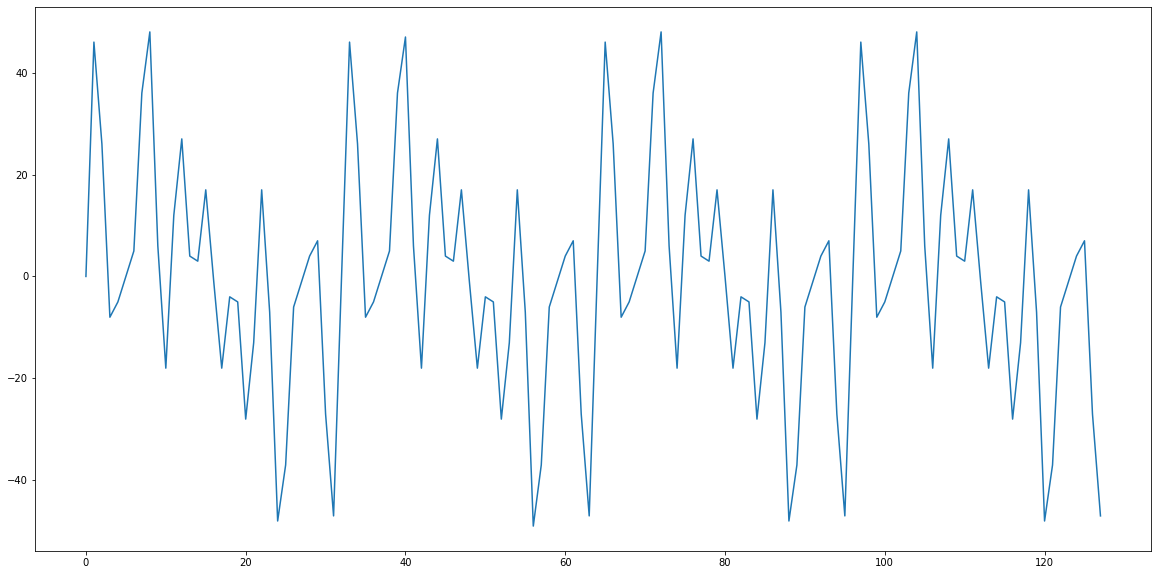

In [26]:
    fig = plt.figure(figsize=(20, 10))
    plt.plot(arr);
    

#### Cálculo de filtro pasa bajos

- Frecuencia de corte 1 kHz

In [33]:
#lowpass = [-0,-0,-0,0,0,3.052e-05,3.052e-05,3.052e-05,0,-3.052e-05,-6.104e-05,-9.155e-05,-0.0001221,-9.155e-05,0,0.0001526,0.0002747,0.0003357,0.0003052,0.0001221,-0.0001831,-0.0005188,-0.0007629,-0.0007935,-0.0005188,6.104e-05,0.0007935,0.001465,0.00177,0.001465,0.0005493,-0.000824,-0.002289,-0.003235,-0.003265,-0.002075,0.0001526,0.002899,0.005188,0.006134,0.005096,0.001953,-0.002625,-0.007233,-0.01025,-0.01025,-0.006561,0.0003052,0.008606,0.01569,0.01874,0.01575,0.006317,-0.007843,-0.02301,-0.03409,-0.03595,-0.02487,0.0003967,0.03769,0.0817,0.125,0.1597,0.1789,0.1789,0.1597,0.125,0.0817,0.03769,0.0003967,-0.02487,-0.03595,-0.03409,-0.02301,-0.007843,0.006317,0.01575,0.01874,0.01569,0.008606,0.0003052,-0.006561,-0.01025,-0.01025,-0.007233,-0.002625,0.001953,0.005096,0.006134,0.005188,0.002899,0.0001526,-0.002075,-0.003265,-0.003235,-0.002289,-0.000824,0.0005493,0.001465,0.00177,0.001465,0.0007935,6.104e-05,-0.0005188,-0.0007935,-0.0007629,-0.0005188,-0.0001831,0.0001221,0.0003052,0.0003357,0.0002747,0.0001526,0,-9.155e-05,-0.0001221,-9.155e-05,-6.104e-05,-3.052e-05,0,3.052e-05,3.052e-05,3.052e-05,0,0,-0,-0,-0]
lowpass = np.load('low_pass_filter.npy')
print(lowpass)
lowpass = np.array(lowpass, dtype=float)
print(lowpass)

[['-0' '-0' '0' '0.03125' '0.1094' '0.25' '0.3906' '0.4531' '0.3906'
  '0.25' '0.1094' '0.03125' '0' '-0' '-0']]
[[-0.      -0.       0.       0.03125  0.1094   0.25     0.3906   0.4531
   0.3906   0.25     0.1094   0.03125  0.      -0.      -0.     ]]


In [34]:
#!pip install fxpmath

In [35]:
print(lowpass)

[[-0.      -0.       0.       0.03125  0.1094   0.25     0.3906   0.4531
   0.3906   0.25     0.1094   0.03125  0.      -0.      -0.     ]]


In [36]:
filename = '../hdl/src/low_pass.hex'
N = len(lowpass)
mem = []

temp  = DeFixedInt(8,6, signedMode='S', roundMode='trunc', saturateMode='saturate')

with open(filename, 'w') as f:
    for coeff in lowpass[0]:
        temp.value = coeff
        print(temp.value)
        f.write("{}\n".format(temp.__hex__()).replace('0x',''))

0
0
0
2
7
16
24
28
24
16
7
2
0
0
0


##### Visualización de la respuesta impulsiva

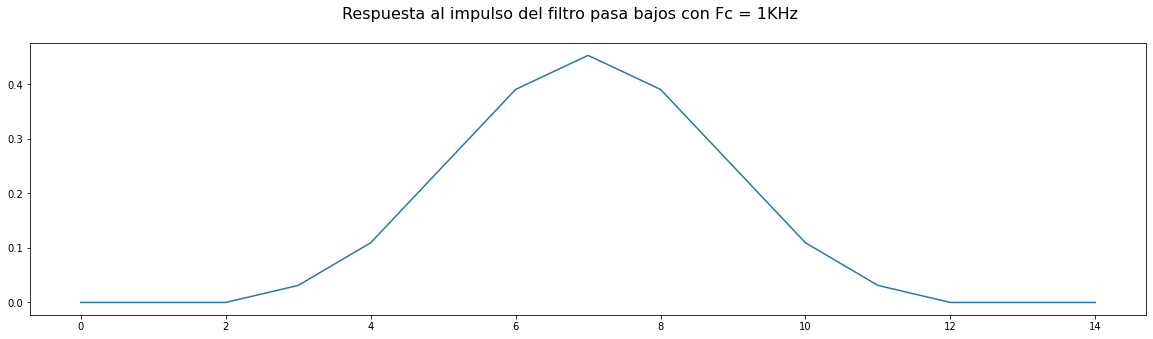

In [37]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Respuesta al impulso del filtro pasa bajos con Fc = 1KHz", fontsize=16)
plt.plot(lowpass[0]);

##### Visualización de la respuesta en frequencia

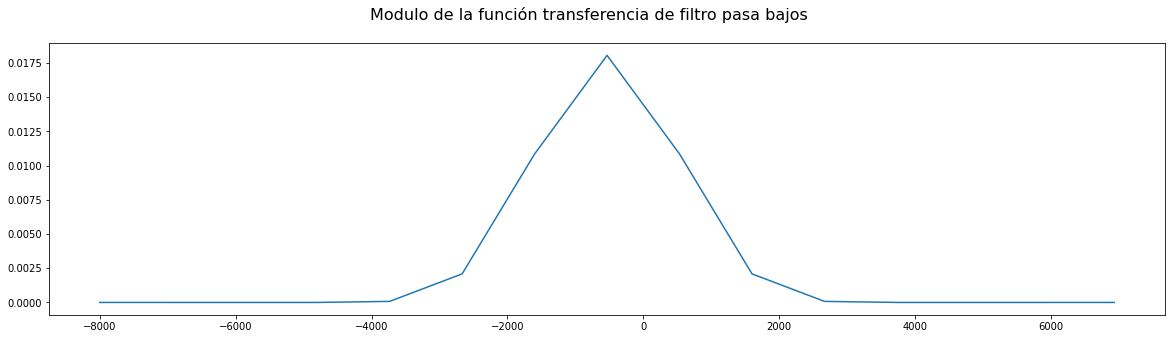

In [39]:
HData  = np.fft.fft(lowpass[0])
circularHData = np.abs(np.fft.fftshift(HData/len(lowpass[0])))**2
f = np.arange(-fs/2, fs/2, fs/len(lowpass[0]))

fig = plt.figure(figsize=(20, 5))
fig.suptitle("Modulo de la función transferencia de filtro pasa bajos", fontsize=16)
plt.plot(f, circularHData);

#### Cálculo de filtro pasa altos

- Frecuencia de corte 1 kHz

In [40]:
# highpass = [-0,0,-0,-0,0,-0,-0,3.052e-05,-3.052e-05,3.052e-05,3.052e-05,-9.155e-05,9.155e-05,0,-0.0001526,0.0002136,-0.0001526,-0.0001221,0.0003662,-0.0004272,0.0001221,0.0003967,-0.0007629,0.0006104,9.155e-05,-0.000946,0.001282,-0.0007019,-0.0006409,0.001862,-0.001892,0.0004272,0.001801,-0.003143,0.00235,0.0005188,-0.003693,0.004669,-0.002197,-0.002563,0.006409,-0.006104,0.0009155,0.006104,-0.009888,0.006775,0.002319,-0.0116,0.01385,-0.005798,-0.008636,0.01965,-0.01782,0.001434,0.02042,-0.03204,0.02124,0.01059,-0.04559,0.05692,-0.02356,-0.05539,0.1566,-0.2414,0.2744,-0.2414,0.1566,-0.05539,-0.02356,0.05692,-0.04559,0.01059,0.02124,-0.03204,0.02042,0.001434,-0.01782,0.01965,-0.008636,-0.005798,0.01385,-0.0116,0.002319,0.006775,-0.009888,0.006104,0.0009155,-0.006104,0.006409,-0.002563,-0.002197,0.004669,-0.003693,0.0005188,0.00235,-0.003143,0.001801,0.0004272,-0.001892,0.001862,-0.0006409,-0.0007019,0.001282,-0.000946,9.155e-05,0.0006104,-0.0007629,0.0003967,0.0001221,-0.0004272,0.0003662,-0.0001221,-0.0001526,0.0002136,-0.0001526,0,9.155e-05,-9.155e-05,3.052e-05,3.052e-05,-3.052e-05,3.052e-05,-0,-0,0,-0,-0,0,-0]
highpass = np.load('high_pass_filter.npy')
print(highpass)
highpass = np.array(highpass, dtype=float)
print(highpass)

[['-0' '0' '-0.01562' '0.0625' '-0.1406' '0.25' '-0.3438' '0.3906'
  '-0.3438' '0.25' '-0.1406' '0.0625' '-0.01562' '0' '-0']]
[[-0.       0.      -0.01562  0.0625  -0.1406   0.25    -0.3438   0.3906
  -0.3438   0.25    -0.1406   0.0625  -0.01562  0.      -0.     ]]


In [43]:
filename = '../hdl/src/high_pass.hex'
N = len(highpass)
mem = []

temp  = DeFixedInt(8,6, signedMode='S', roundMode='trunc', saturateMode='saturate')

with open(filename, 'w') as f:
    for coeff in highpass[0]:
        temp.value = coeff
        print(temp.value)
        f.write("{}\n".format(temp.__hex__()).replace('0x',''))

0
0
-1
4
-9
16
-23
24
-23
16
-9
4
-1
0
0


##### Visualización de la respuesta impulsiva

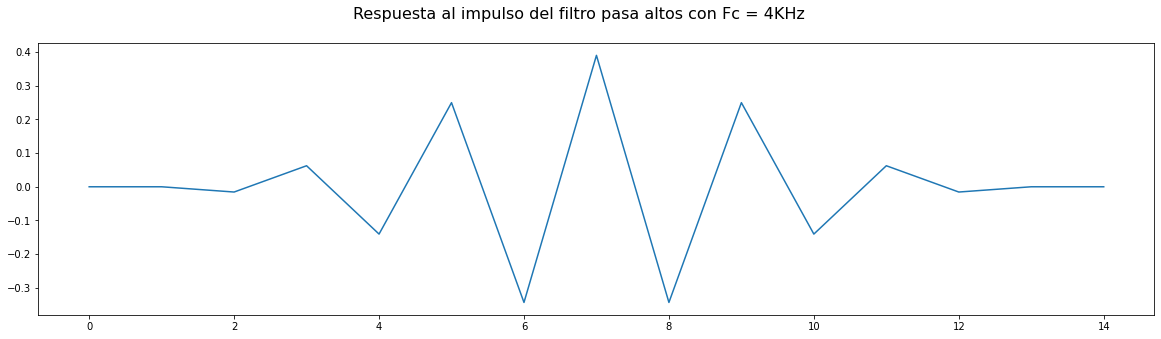

In [41]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Respuesta al impulso del filtro pasa altos con Fc = 4KHz", fontsize=16)
plt.plot(highpass[0]);

##### Visualización de la respuesta en frequencia

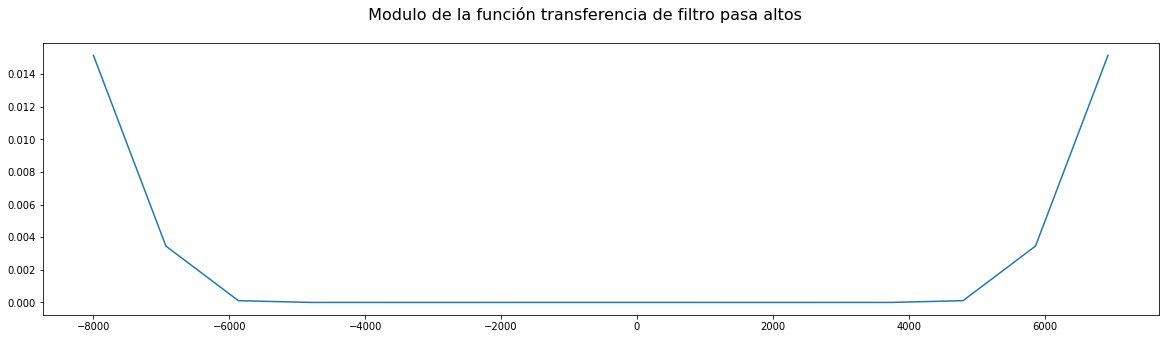

In [42]:
HData  = np.fft.fft(highpass[0])
circularHData = np.abs(np.fft.fftshift(HData/len(highpass[0])))**2
f = np.arange(-fs/2, fs/2, fs/len(highpass[0]))

fig = plt.figure(figsize=(20, 5))
fig.suptitle(" Modulo de la función transferencia de filtro pasa altos", fontsize=16)
plt.plot(f, circularHData);

#### Cálculo de filtro pasa banda

- Frecuencia de corte inferior 2 kHz
- Frecuencia de corte superior 3.5 kHz

In [9]:
bandpass = [0,-0,-0,0,0,0,3.052e-05,-6.104e-05,-6.104e-05,9.155e-05,6.104e-05,-6.104e-05,-0,-9.155e-05,-0.0001526,0.0003662,0.0003357,-0.0004883,-0.0002747,0.0001221,-0.0001831,0.0006714,0.000824,-0.001434,-0.00116,0.001312,0.0005188,0.0002747,0.001129,-0.002625,-0.002777,0.003937,0.002838,-0.002319,-0.0001831,-0.00238,-0.004181,0.007385,0.007172,-0.00827,-0.005188,0.002228,-0.002563,0.008698,0.01202,-0.01712,-0.01553,0.0145,0.006897,0.002167,0.01251,-0.02521,-0.0314,0.03802,0.03268,-0.02362,-0.00351,-0.02396,-0.05502,0.09314,0.1248,-0.1581,-0.1781,0.1912,0.1912,-0.1781,-0.1581,0.1248,0.09314,-0.05502,-0.02396,-0.00351,-0.02362,0.03268,0.03802,-0.0314,-0.02521,0.01251,0.002167,0.006897,0.0145,-0.01553,-0.01712,0.01202,0.008698,-0.002563,0.002228,-0.005188,-0.00827,0.007172,0.007385,-0.004181,-0.00238,-0.0001831,-0.002319,0.002838,0.003937,-0.002777,-0.002625,0.001129,0.0002747,0.0005188,0.001312,-0.00116,-0.001434,0.000824,0.0006714,-0.0001831,0.0001221,-0.0002747,-0.0004883,0.0003357,0.0003662,-0.0001526,-9.155e-05,-0,-6.104e-05,6.104e-05,9.155e-05,-6.104e-05,-6.104e-05,3.052e-05,0,0,0,-0,-0,0]

##### Visualización de la respuesta impulsiva

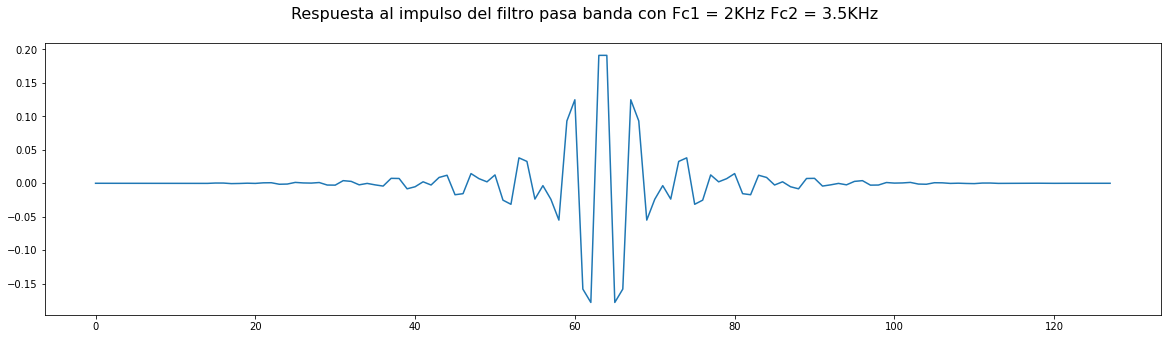

In [10]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Respuesta al impulso del filtro pasa banda con Fc1 = 2KHz Fc2 = 3.5KHz", fontsize=16)
plt.plot(bandpass);

##### Visualización de la respuesta en frequencia

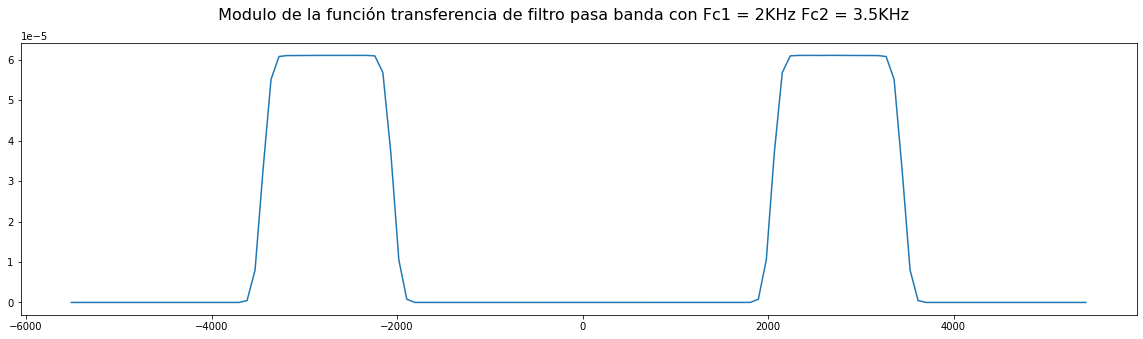

In [11]:
HData  = np.fft.fft(bandpass)
circularHData = np.abs(np.fft.fftshift(HData/len(bandpass)))**2
f = np.arange(-fs/2, fs/2, fs/len(bandpass))

fig = plt.figure(figsize=(20, 5))
fig.suptitle(" Modulo de la función transferencia de filtro pasa banda con Fc1 = 2KHz Fc2 = 3.5KHz", fontsize=16)
plt.plot(f, circularHData);

#### Cálculo de filtro suprime banda

- Frecuencia de corte inferior 2 kHz
- Frecuencia de corte inferior 3.5 kHz

In [12]:
deleteBand = [-0,0,0,-0,-0,0,-3.052e-05,0,9.155e-05,-3.052e-05,-0.0001526,3.052e-05,6.104e-05,0,0.0002136,-6.104e-05,-0.0005493,9.155e-05,0.0005798,-6.104e-05,6.104e-05,-9.155e-05,-0.00116,0.0002441,0.001953,-0.0002747,-0.001343,3.052e-05,-0.001068,0.0003357,0.004059,-0.0005798,-0.005005,0.0004272,0.00177,0.0001526,0.004913,-0.0007935,-0.01071,0.001007,0.009796,-0.0004883,0.0003357,-0.0005798,-0.01517,0.001434,0.02377,-0.001343,-0.0155,0.0002136,-0.01065,0.001221,0.04095,-0.001984,-0.05127,0.001343,0.02026,0.0003052,0.05551,-0.001862,-0.1547,0.002136,0.239,-0.000946,0.7279,-0.000946,0.239,0.002136,-0.1547,-0.001862,0.05551,0.0003052,0.02026,0.001343,-0.05127,-0.001984,0.04095,0.001221,-0.01065,0.0002136,-0.0155,-0.001343,0.02377,0.001434,-0.01517,-0.0005798,0.0003357,-0.0004883,0.009796,0.001007,-0.01071,-0.0007935,0.004913,0.0001526,0.00177,0.0004272,-0.005005,-0.0005798,0.004059,0.0003357,-0.001068,3.052e-05,-0.001343,-0.0002747,0.001953,0.0002441,-0.00116,-9.155e-05,6.104e-05,-6.104e-05,0.0005798,9.155e-05,-0.0005493,-6.104e-05,0.0002136,0,6.104e-05,3.052e-05,-0.0001526,-3.052e-05,9.155e-05,0,-3.052e-05,0,-0,-0,0,0,-0]

##### Visualización de la respuesta impulsiva

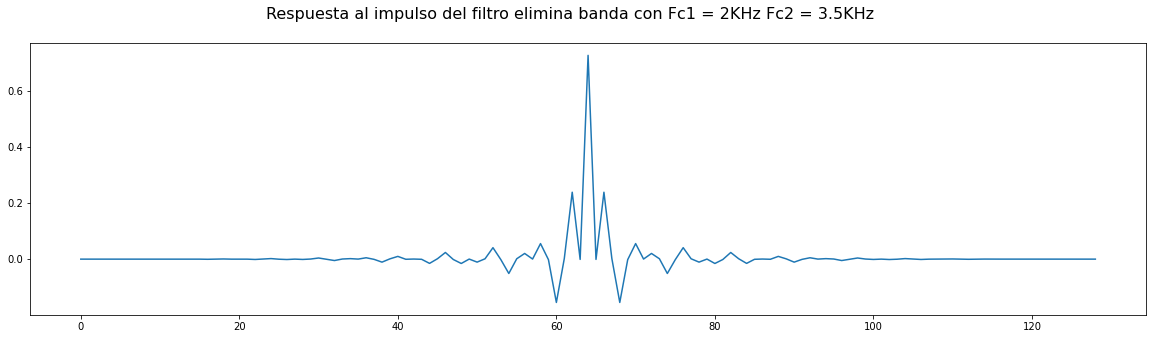

In [13]:
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Respuesta al impulso del filtro elimina banda con Fc1 = 2KHz Fc2 = 3.5KHz", fontsize=16)
plt.plot(deleteBand);

##### Visualización de la respuesta en frequencia

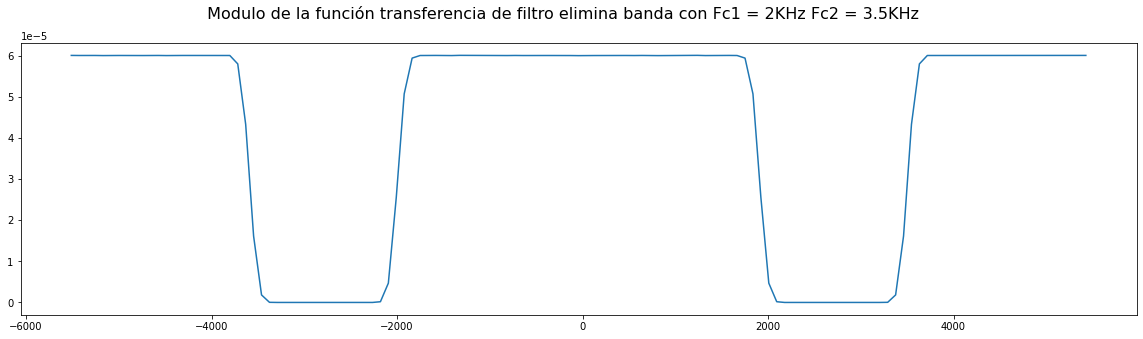

In [14]:
HData  = np.fft.fft(deleteBand)
circularHData = np.abs(np.fft.fftshift(HData/len(deleteBand)))**2
f = np.arange(-fs/2, fs/2, fs/len(deleteBand))

fig = plt.figure(figsize=(20, 5))
fig.suptitle(" Modulo de la función transferencia de filtro elimina banda con Fc1 = 2KHz Fc2 = 3.5KHz", fontsize=16)
plt.plot(f, circularHData);

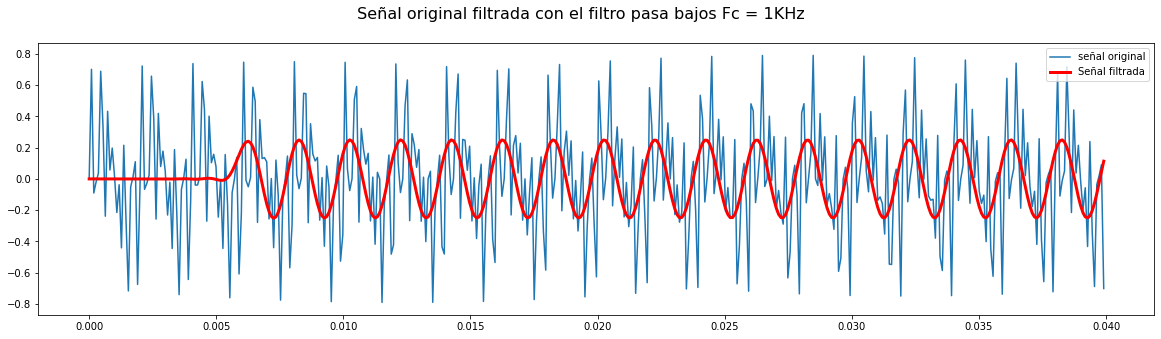

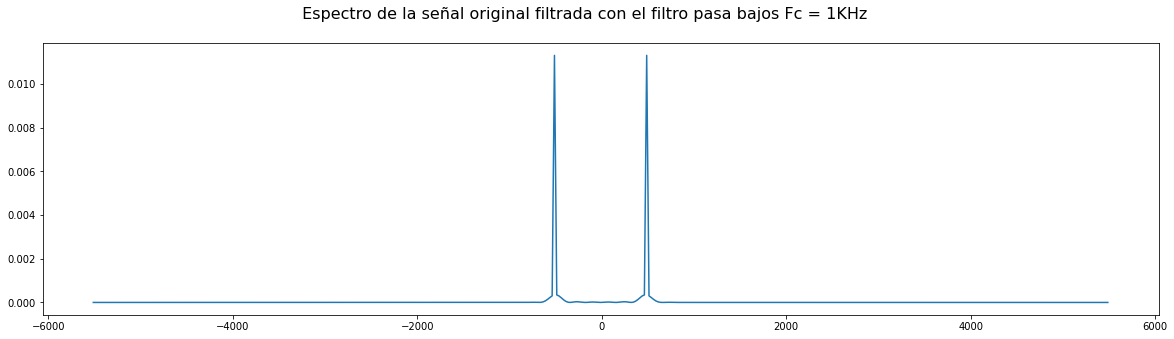

In [15]:
# Uso lfilter para filtrar la señal inicial con el filtro FIR pasa bajos
signalLowpass = lfilter(lowpass, 1.0, tones)

# Calculo del expecttro de la señal filtrada
fftSignalFiltered = np.fft.fft(signalLowpass)
fftSignalFilteredCircular = np.abs(np.fft.fftshift(fftSignalFiltered)/len(fftSignalFiltered))**2
f = np.arange(-fs/2,fs/2,fs/len(fftSignalFilteredCircular))


fig = plt.figure(figsize=(20, 5))
fig.suptitle(" Señal original filtrada con el filtro pasa bajos Fc = 1KHz", fontsize=16)
plot.plot(t, tones, label='señal original')
plot.plot(t, signalLowpass, 'r-', linewidth=3, label='Señal filtrada') 
plot.legend()

fig = plt.figure(figsize=(20,5))
fig.suptitle(" Espectro de la señal original filtrada con el filtro pasa bajos Fc = 1KHz", fontsize=16)
signalFiltered, = plt.plot(f, fftSignalFilteredCircular)

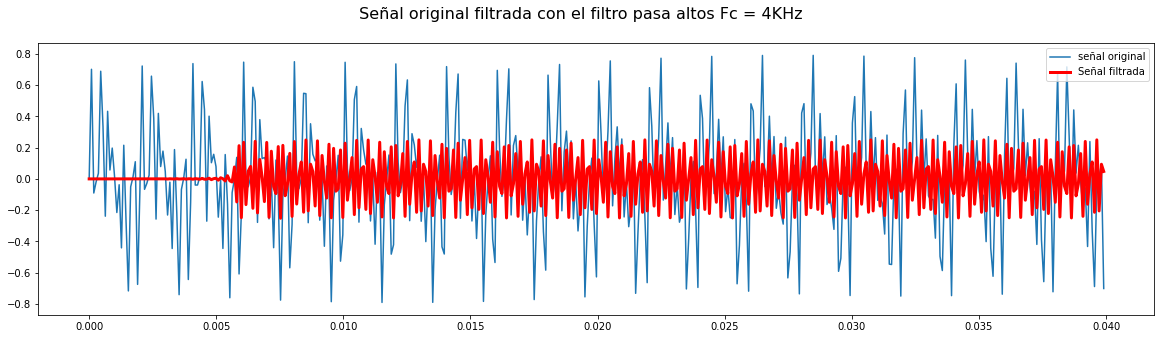

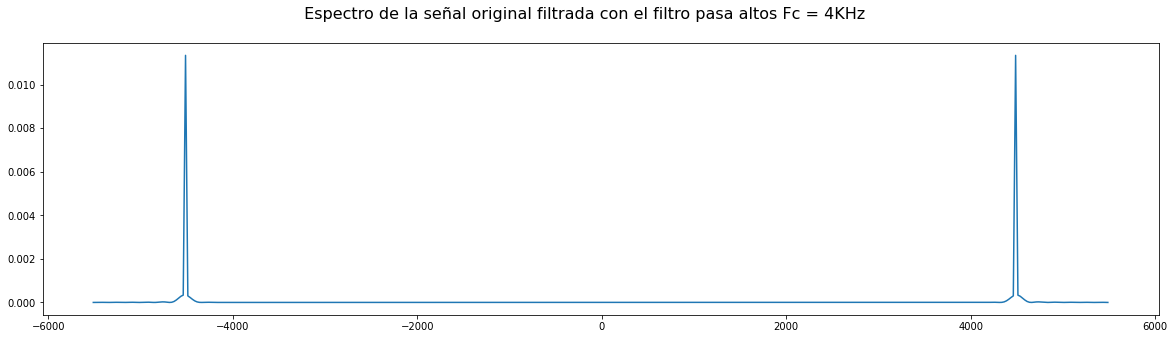

In [16]:
# Uso lfilter para filtrar la señal inicial con el filtro FIR pasa altos
signalHighpass = lfilter(highpass, 1.0, tones)

# Calculo del expecttro de la señal filtrada
fftSignalFiltered = np.fft.fft(signalHighpass)
fftSignalFilteredCircular = np.abs(np.fft.fftshift(fftSignalFiltered)/len(fftSignalFiltered))**2
f = np.arange(-fs/2,fs/2,fs/len(fftSignalFilteredCircular))

fig = plt.figure(figsize=(20, 5))
fig.suptitle(" Señal original filtrada con el filtro pasa altos Fc = 4KHz", fontsize=16)
plot.plot(t, tones, label='señal original')
plot.plot(t, signalHighpass,'r-', linewidth=3, label='Señal filtrada') 
plot.legend()

fig = plt.figure(figsize=(20,5))
fig.suptitle(" Espectro de la señal original filtrada con el filtro pasa altos Fc = 4KHz", fontsize=16)
signalFiltered, = plt.plot(f, fftSignalFilteredCircular)

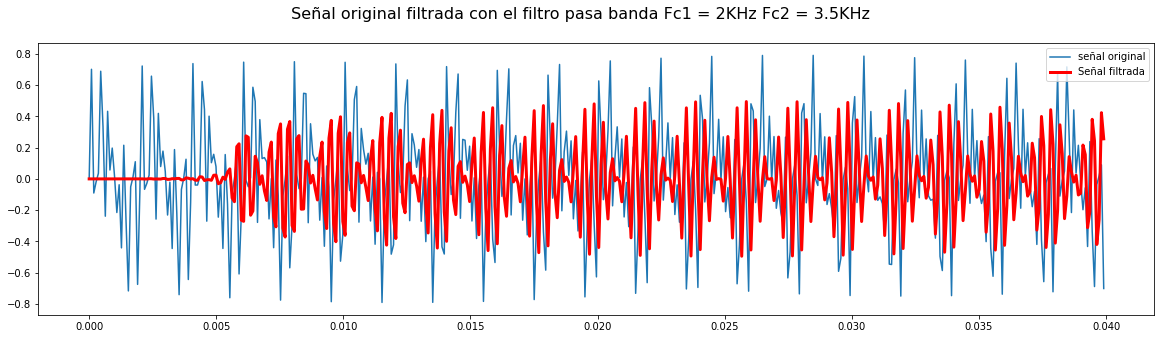

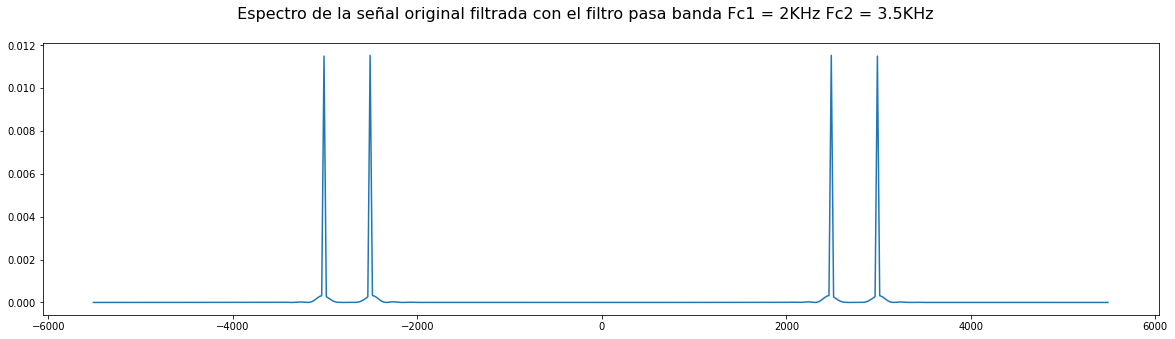

In [17]:
# Uso lfilter para filtrar la señal inicial con el filtro FIR pasa banda
signalBandpass = lfilter(bandpass, 1.0, tones)

# Calculo del expecttro de la señal filtrada
fftSignalFiltered = np.fft.fft(signalBandpass)
fftSignalFilteredCircular = np.abs(np.fft.fftshift(fftSignalFiltered)/len(fftSignalFiltered))**2
f = np.arange(-fs/2,fs/2,fs/len(fftSignalFilteredCircular))

fig = plt.figure(figsize=(20, 5))
fig.suptitle(" Señal original filtrada con el filtro pasa banda Fc1 = 2KHz Fc2 = 3.5KHz", fontsize=16)
plot.plot(t, tones, label='señal original')
plot.plot(t, signalBandpass, 'r-', linewidth=3, label='Señal filtrada') 
plot.legend()

fig = plt.figure(figsize=(20,5))
fig.suptitle(" Espectro de la señal original filtrada con el filtro pasa banda Fc1 = 2KHz Fc2 = 3.5KHz", fontsize=16)
signalFiltered, = plt.plot(f, fftSignalFilteredCircular)

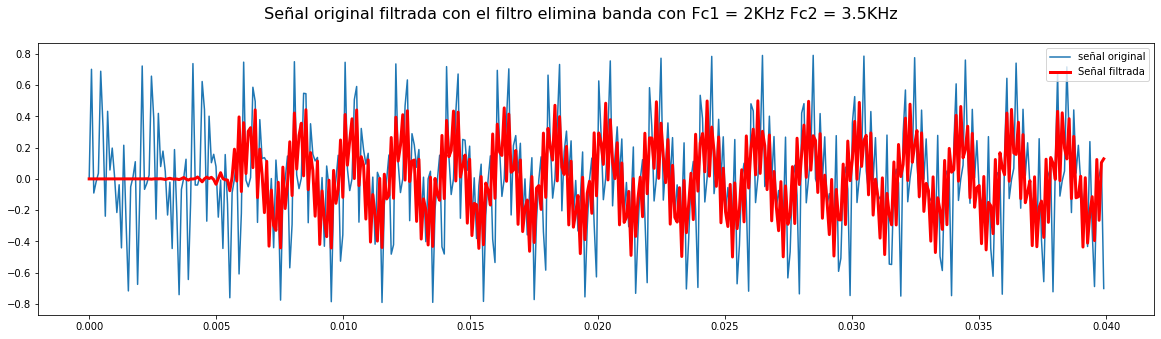

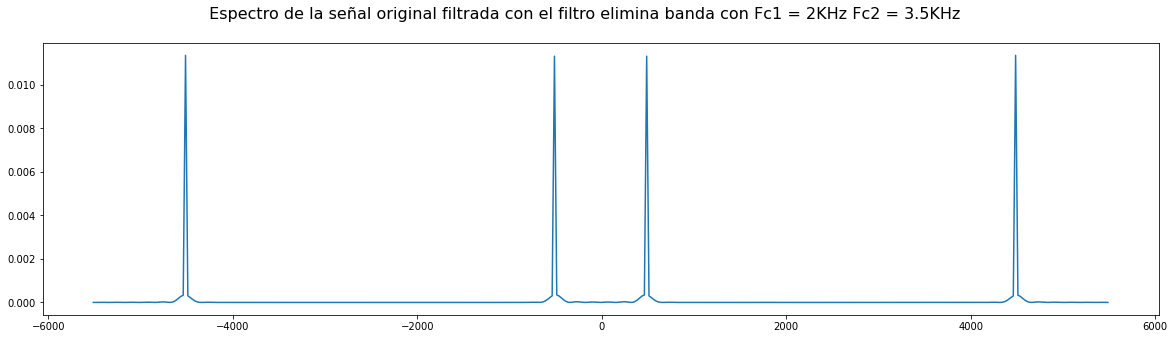

In [18]:
# Uso lfilter para filtrar la señal inicial con el filtro FIR elimina banda
signaldeleteBand = lfilter(deleteBand, 1.0, tones)

# Calculo del expecttro de la señal filtrada
fftSignalFiltered = np.fft.fft(signaldeleteBand)
fftSignalFilteredCircular = np.abs(np.fft.fftshift(fftSignalFiltered)/len(fftSignalFiltered))**2
f = np.arange(-fs/2,fs/2,fs/len(fftSignalFilteredCircular))

fig = plt.figure(figsize=(20, 5))
fig.suptitle(" Señal original filtrada con el filtro elimina banda con Fc1 = 2KHz Fc2 = 3.5KHz", fontsize=16)
plot.plot(t, tones, label='señal original')
plot.plot(t, signaldeleteBand, 'r-', linewidth=3, label='Señal filtrada') 
plot.legend()

fig = plt.figure(figsize=(20,5))
fig.suptitle(" Espectro de la señal original filtrada con el filtro elimina banda con Fc1 = 2KHz Fc2 = 3.5KHz", fontsize=16)
signalFiltered, = plt.plot(f, fftSignalFilteredCircular)